In [1]:
from kural_core.imports import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
PATH = r'D:\Code\kural_work\movie_generation\data\\'

In [2]:
with open(PATH + 'img_files_and_n_frames.pickle', 'rb') as f:
    file_list = pickle.load(f)

In [3]:
imgs = torch.zeros((10000, 256, 256), dtype=torch.float)

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    img_files = [ND2Reader(file['name']) for file in file_list['id']]

In [4]:
for k in range(1,20):
    print(k)
    imgs = torch.zeros((10000, 256, 256), dtype=torch.float)
    for i in tqdm(range(imgs.shape[0])):
        idx = choice(len(file_list['id']))
        img_file =  img_files[idx]
        frame = choice(file_list['id'][idx]['n_frames'])
        img = img_file.get_frame_2D(t=frame)
        img = np.float32(img)
        img = torch.tensor(img)[None,None]
        img = random_affine_transform(random_crop([img], out_size=(256,256)))[0][0,0]
        img = shaking_sand(img)
        imgs[i] = (img - img.mean())/img.std()

    with open(PATH + f'imgs{k}.pickle', 'wb') as f:
        pickle.dump(imgs, f, protocol=4)

1


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:04<00:00, 21.74it/s]


2


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:45<00:00, 21.47it/s]


3


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:13<00:00, 20.27it/s]


4


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:10<00:00, 20.37it/s]


5


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:08<00:00, 20.47it/s]


6


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:15<00:00, 20.17it/s]


7


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:37<00:00, 19.33it/s]


8


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:55<00:00, 16.39it/s]


9


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:17<00:00, 16.20it/s]


10


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:29<00:00, 15.79it/s]


11


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:36<00:00, 14.35it/s]


12


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:44<00:00, 21.51it/s]


13


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:08<00:00, 20.48it/s]


14


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:37<00:00, 15.20it/s]


15


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:39<00:00, 16.13it/s]


16


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:07<00:00, 14.98it/s]


17


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:10<00:00, 14.91it/s]


18


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:08<00:00, 18.22it/s]


19


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:10<00:00, 20.46it/s]


In [2]:
start = time.perf_counter()
with open(PATH + 'imgs0.pickle', 'rb') as f:
    imgs = pickle.load(f)
print(time.perf_counter()-start)

3.858625307999999


In [10]:
from kural_core.data_processing import SimpleAEDataset

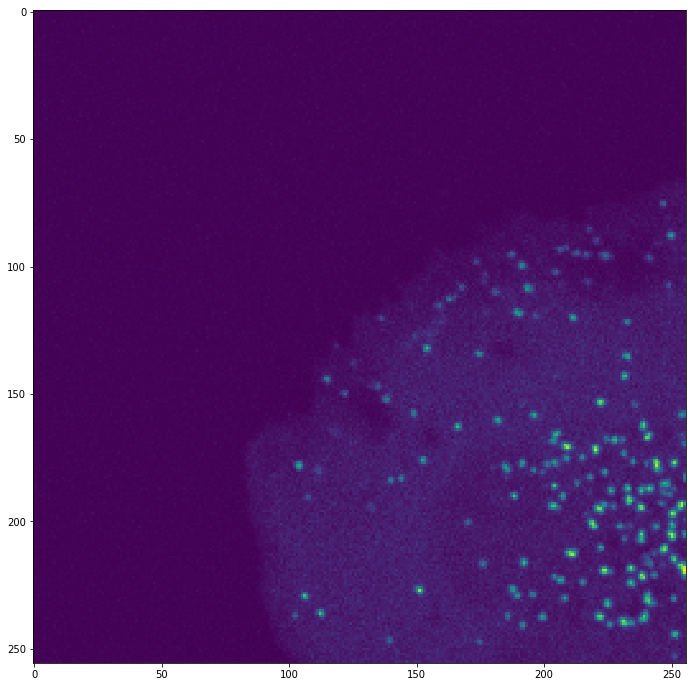

In [26]:
idx = choice(imgs.shape[0])
plt.imshow(imgs[idx])
plt.show()

In [2]:
file = 'as02_10m_2s_100ms_25p.tif'

In [89]:
img_ = Image.open(PATH+file)
nf = img_.n_frames
h = img_.height
w = img_.width
imgs = np.zeros((nf,h,w))
for f in range(nf):
    img_.seek(f)
    imgs[f,:,:] = np.asarray(list(img_.getdata())).reshape(h,w)

In [90]:
imgs[imgs==np.max(imgs)] = 0

In [91]:
imgs = torch.tensor(imgs).float()

In [5]:
def shaking_sand(img):
    alt_img = img.detach().cuda()
    s2 = np.sqrt(2)
    alpha = 0.05
    kernel = torch.tensor([[-1, -s2, -1], [-s2, 4*(1+s2), -s2], [-1, -s2, -1]]).reshape(1,1,3,3).cuda()
    for i in range(100):
        diverge = nn.functional.conv2d(alt_img[None,None], kernel, padding=1)
        alt_img -= (-1)**i*alpha*diverge[0,0]
    return alt_img.cpu()
    

In [118]:
ss_imgs = torch.zeros_like(imgs)
for i in range(imgs.shape[0]):
    ss_imgs[i] = shaking_sand(imgs[i])

In [2]:
model = ConvolutionalAutoencoder256Model().cuda()
opt = torch.optim.Adam(model.parameters())
train_loss = []
val_loss = []
criterion = nn.MSELoss()
model.load_state_dict(torch.load(PATH+'AE_with_lots_of_data.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [3]:
for i in tqdm(range(2000)):
    k = choice(20)
    with open(PATH + f'imgs{k}.pickle', 'rb') as f:
        imgs = pickle.load(f)
    ds = SimpleAEDataset(imgs)
    train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, nORp=1)
    bs = 50
    clip = 50
    train_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
    val_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(val_idx))

    model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, epochs=1, pprint=False)
    train_loss += _tl
    val_loss += _vl
    torch.save(model.state_dict(),PATH+'AE_with_lots_of_data.pth')

 53%|█████████████████████████████████████▋                                 | 1063/2000 [46:13:21<38:53:17, 149.41s/it]

KeyboardInterrupt: 

In [4]:
k = choice(20)
with open(PATH + f'imgs{k}.pickle', 'rb') as f:
    imgs = pickle.load(f)

In [175]:
model = ConvolutionalAutoencoder256Model().cuda()
opt = torch.optim.Adam(model.parameters())
train_loss = []
val_loss = []
criterion = nn.L1Loss()

In [176]:
ds = SimpleAEDataset(imgs)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, nORp=1)
bs = 50
clip = 50
train_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds, batch_size=bs, sampler=SubsetSampler(val_idx))

In [226]:
with open(PATH+'stuff_to_resume_training_AE_with_lots_of_data.pth', 'wb') as f:
    pickle.dump((imgs, train_idx, val_idx, train_loss, val_loss), f, protocol=4)

In [197]:
model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, epochs=200)
train_loss += _tl
val_loss += _vl
torch.save(model.state_dict(),PATH+'AE_with_lots_of_data.pth')

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 405m 52s doing 200 total steps for an average of 121.8s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


In [92]:
lr_range = [1e-6*(10**(i/5)) for i in range(30)]
for lr in lr_range:
    model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=lr, lr_end=None, epochs=1)
    train_loss += _tl
    val_loss += _vl
    if _tl[0]>100: break

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 0m  0s doing 1 total steps for an average of 0.2s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


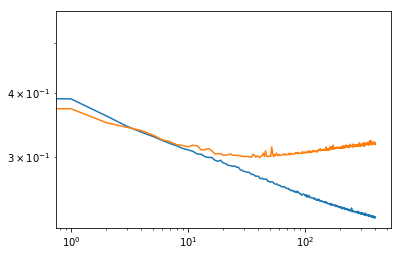

In [198]:
x = list(range(len(train_loss)))
# x = lr_range
slc = slice(0,len(train_loss))
plt.plot(x[slc],train_loss[slc])
plt.plot(x[slc],val_loss[slc])
plt.xscale('log')
plt.yscale('log')
# plt.ylim(.9, 2)
plt.show()

In [125]:
train_loss

[0.758350670337677,
 0.7583273649215698,
 0.7582999467849731,
 0.7582666873931885,
 0.7582224607467651,
 0.7581645846366882,
 0.7580872178077698,
 0.7579822540283203,
 0.7578383684158325,
 0.7576407194137573,
 0.7573663592338562,
 0.7569857835769653,
 0.7564681768417358,
 0.7557739019393921,
 0.7544536590576172,
 0.7472766041755676,
 0.7047203779220581,
 1.0927784442901611,
 0.69829922914505,
 0.7410753965377808,
 0.74683678150177,
 0.7474464178085327,
 0.747503936290741,
 0.7476698160171509,
 0.7477201223373413,
 0.7474206686019897,
 0.7467767000198364,
 0.7460958361625671,
 0.7456163167953491,
 0.7451068162918091,
 0.7442715764045715,
 0.7429744005203247,
 0.7414664626121521,
 0.7398456335067749,
 0.7378364205360413,
 0.7356750965118408,
 0.7331264019012451,
 0.7298772931098938,
 0.7254322171211243,
 0.7184688448905945,
 0.7084248065948486,
 0.6922070980072021,
 0.6805232763290405,
 0.6605452299118042,
 0.6448140144348145,
 0.6209625005722046,
 0.5957626700401306,
 0.575128972530365,

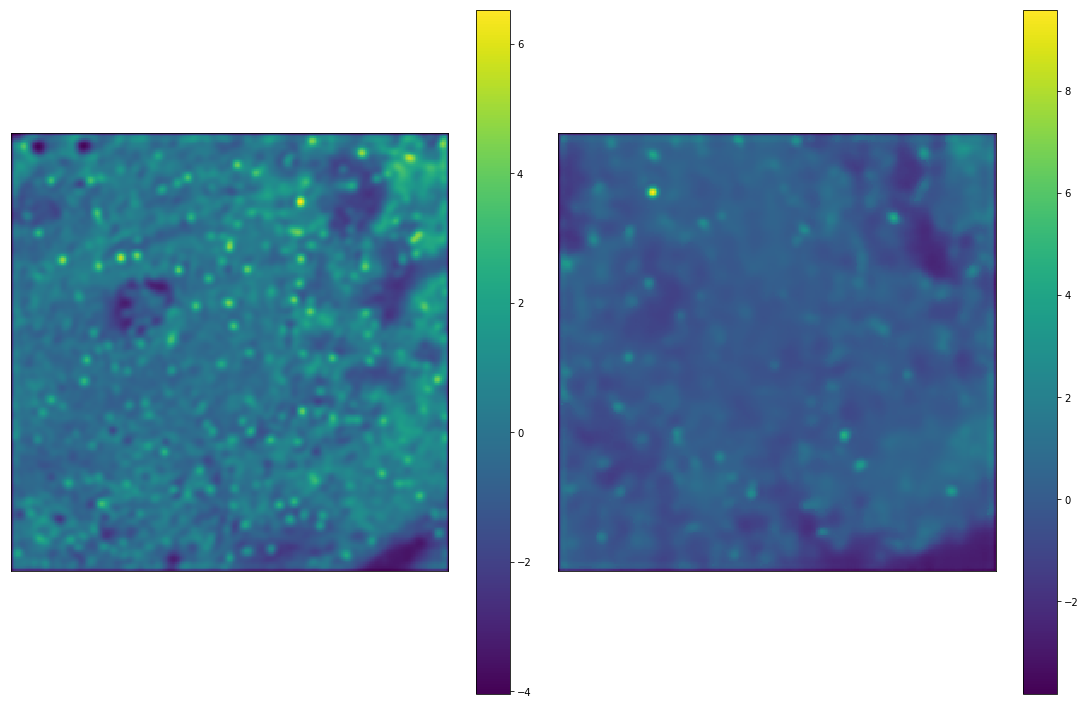

In [225]:
idx = np.random.choice(val_idx)
img = ds[idx][0]
y_pred = model(img[None].cuda()).data.cpu()
plot_multiple([img[0], y_pred[0,0]], colorbar=True)

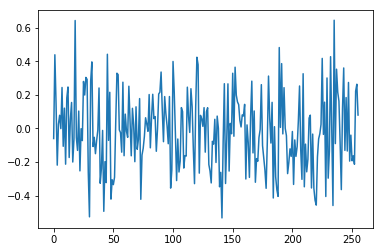

In [89]:
plt.plot(model.convolution(img[None].cuda()).squeeze().data.cpu().numpy())

In [49]:
img.mean()

tensor(-1.1921e-07)

In [32]:
img

(tensor([[[-0.7386, -0.6850, -1.0700,  ..., -0.6973, -0.5040, -0.9926],
          [-0.8065, -0.9296, -0.7784,  ..., -0.7460, -0.6980, -0.2657],
          [-0.4285, -0.8678, -0.1316,  ..., -0.6055, -0.4760, -0.7181],
          ...,
          [ 1.3381,  0.3728,  0.2652,  ..., -0.8701, -0.7824, -0.7593],
          [-0.0256, -0.6072,  0.4263,  ..., -0.9852, -0.8233, -0.9095],
          [ 0.1145, -0.0792,  1.4345,  ..., -0.9213, -0.6613, -0.7883]]]),
 tensor([[[-0.7386, -0.6850, -1.0700,  ..., -0.6973, -0.5040, -0.9926],
          [-0.8065, -0.9296, -0.7784,  ..., -0.7460, -0.6980, -0.2657],
          [-0.4285, -0.8678, -0.1316,  ..., -0.6055, -0.4760, -0.7181],
          ...,
          [ 1.3381,  0.3728,  0.2652,  ..., -0.8701, -0.7824, -0.7593],
          [-0.0256, -0.6072,  0.4263,  ..., -0.9852, -0.8233, -0.9095],
          [ 0.1145, -0.0792,  1.4345,  ..., -0.9213, -0.6613, -0.7883]]]))